# Our initialization strategy

This notebook implements the algorithms for computing weights and biases of our new initialization strategy for neural networks. The neural networks we work with have (rank $k$) max-out activation functions, which means each unit performs
$$x \mapsto max(a_{i, 1}w_i*x + b_{i, 1}, \ a_{i, 2}w_i*x + b_{i, 2},\ \ldots \ ,\ a_{i, k}w_i*x + b_{i, k} )$$
on the input.

The proposed initialization strategy follows three steps (per layer of size $m_l$):
1. Sample weights $\{ w_i \}_{i = 1, \ldots, m_l}$ from the unit sphere (uniformly) for all units in the layer.
2. Pick a subset $X \subseteq \mathcal{X}$ of size $N$ of the unlabelled data set (where $N$ is a parameter set by the user).
3. For unit $i$, pick $\{ a_{i, j} \}_{j = 1, \ldots, k} \subseteq \mathbb{R}$. Set $\{ b_{i, j} \}_{j = 1, \ldots, k}$ so that the linear regions $R_{i, j}$ contain approximately the same number of points in $X$, i.e. $|X \cap R_{i, j}|$ is independent of $j$.

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import math

np.random.seed(65432)

In [51]:
k = 10     # rank of max-out
m_l = 16   # size of the layer

## Generating an input dataset

To test our method, we generate a dataset of points in $\mathbb{R}^3$. Since this data set will be "small enough", the step 2 of the initialization strategy can be skipped. 

In [52]:
d = 3      # dimension of the ambient space
N = 1000   # size of the data set

In [53]:
X = np.random.normal(0, 1, (N, d))

Let us visualize the generated data

In [54]:
xs = X[:, 0]
ys = X[:, 1]
zs = X[:, 2]

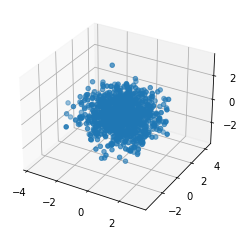

In [55]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(xs, ys, zs)

## Sampling weights

To sample weights uniformly, we will sample them from a normal distribution around the origin and then normalize them.

In [56]:
def sample_weights(nr_weights, dimension):
    W = np.random.normal(0, 1, (nr_weights, dimension))
    
    for i in range(nr_weights):
        w_i = W[i,:]
        while np.array_equal(w_i, np.zeros(dimension)):
            w_i = np.random.normal(0, 1, (1, dimension))
        norm = np.linalg.norm(w_i)
        W[i, :] = w_i/norm
    return W            

In [57]:
W = sample_weights(m_l, d)

Let us visualize the weights. 

In [58]:
Wxs=W[:, 0]
Wys=W[:, 1]
Wzs=W[:, 2]

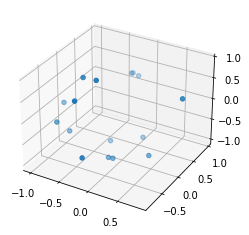

In [59]:
fig1 = plt.figure()
Wax = fig1.add_subplot(projection='3d')
Wax.scatter(Wxs, Wys, Wzs)

## Sampling the borders of linear regions

In this part we focus on a single unit with weight $w_0$. First compute the (length of the) projections of data points in $X$ onto the line $\{ \alpha w_0 \}_{\alpha \in \mathbb{R}}$.

In [60]:
def calculate_projections(w, data):
    data_size, b = data.shape 
    c = 0
    proj = np.zeros(data_size)
    for x in data:
        proj[c] = np.dot(x, w)
        c= c+1
    return proj

In [61]:
proj = np.sort(calculate_projections(W[0, :], X))
print(proj)

[-3.41823963e+00 -3.19344267e+00 -3.09213842e+00 -2.99466982e+00
 -2.69151483e+00 -2.60612783e+00 -2.56472834e+00 -2.50262445e+00
 -2.49260315e+00 -2.31217207e+00 -2.28769249e+00 -2.22138790e+00
 -2.18732912e+00 -2.15784219e+00 -2.13227024e+00 -2.11638264e+00
 -2.09027059e+00 -2.04058707e+00 -2.01361811e+00 -2.01061739e+00
 -2.00803773e+00 -1.97958170e+00 -1.96078571e+00 -1.95529448e+00
 -1.93562215e+00 -1.93203941e+00 -1.90277209e+00 -1.88688516e+00
 -1.88415911e+00 -1.87218824e+00 -1.86445673e+00 -1.85156934e+00
 -1.82760057e+00 -1.81178928e+00 -1.80790103e+00 -1.80551897e+00
 -1.79553771e+00 -1.76644975e+00 -1.75565779e+00 -1.75137850e+00
 -1.74579182e+00 -1.72612526e+00 -1.72497032e+00 -1.71323449e+00
 -1.70849912e+00 -1.69463645e+00 -1.68936231e+00 -1.67793816e+00
 -1.64844659e+00 -1.63621100e+00 -1.63547184e+00 -1.62575717e+00
 -1.62083194e+00 -1.61659410e+00 -1.60991839e+00 -1.60278617e+00
 -1.60198607e+00 -1.58214511e+00 -1.58115892e+00 -1.57343872e+00
 -1.56432290e+00 -1.56027

We need to put $k-1$ lines in between these projections so that the number of projections between each consecutive lines is the same. We calculate the batch size and the splits.

In [62]:
batch_size = math.floor(N/k)
print(batch_size)

100


In [63]:
def compute_splits(projections, batch_size, k):
    splits = np.zeros(k-1)
    for i in range (k-1):
        splits[i]=projections[(i+1)*batch_size - 1] + projections[(i+1)*batch_size]
    return splits

In [64]:
splits = compute_splits(proj, batch_size, k)

We sample the factors $\{ a_{0, j}\}_{j=1, \ldots, k}$ from $\mathcal{U}([0, 1])$ and choose $\{ b_{0, j}\}_{j=1, \ldots, k}$ according to the criteria in step 3 above.

In [65]:
ai = np.random.uniform(0, 1, (k, 1))

In [66]:
ai

array([[0.92497293],
       [0.71797186],
       [0.36988848],
       [0.02301244],
       [0.63159881],
       [0.87502392],
       [0.52411215],
       [0.1882721 ],
       [0.08104331],
       [0.77726839]])

Assume you choose a $b_0 = 0.01$.

In [67]:
b_0 = 0.01

Given $b_0$ we can now inductively compute the remaining biases using the formula $$b_{i+1} = b_{i} + s_{i}(a_2-a_1),$$ where $s_i$ is the split between the projection of the $i$-th and the $i+1$-st data point to the line spanned by the weight.

In [68]:
def compute_biases(ai, b_0, splits):
    biases = np.zeros(ai.shape)
    biases[0]=b_0
    for i in range(len(ai)-1):
        if ai[i] == ai[i+1]:
            return None
        biases[i+1] = biases[i] + splits[i]*(ai[i+1]-ai[i])
    return biases

In [69]:
biases = compute_biases(ai, b_0, splits)
biases

array([[0.01      ],
       [0.55894465],
       [1.09873541],
       [1.44530017],
       [1.19382215],
       [1.20900667],
       [1.01685975],
       [0.64890243],
       [0.4654488 ],
       [2.37640311]])

## Putting it all together

Let us define a function `initialize` that takes the parameters:
1. `X` ... data given in a form of a matrix,
2. `layer_size` ... number of units in the layer,
3. `maxout_rank` ... number of linear regions of the maxout activation,
4. `b0s` ... the vector of $b_{i, 0}$,

and returns the following (in the given order):

1. `A` ... `layer_size`$\times$ `maxout_rank`-array of factors,
2. `W` ... array of `layer_size` $d$-dimensional weight vectors (1 per unit),
3. `B` ... `layer_size`$\times$`maxout_rank`-array of biases.

In [70]:
def initialize(data, layer_size, maxout_rank, b0s):
    N, d = data.shape                                       # compute the dimension of the ambient space and #pts
    A = np.random.uniform(0, 1, (layer_size, maxout_rank))  # initialize the array of factors
    B = np.zeros(shape=(layer_size, maxout_rank))           # initialize the array of biases
    batch_size = math.floor(N/maxout_rank)                  # compute the batch size (for computing splits)
    
    W = sample_weights(layer_size, d)                       # sample the weights for each unit
    
    for i in range(layer_size):                                             # loop over all units
        projections = calculate_projections(W[i, :], data)                  # calculate proj. of pts onto weight
        splits = compute_splits(projections, batch_size, maxout_rank)       # calculate splits between batches
        B[i, :] = compute_biases(A[i, :], b0s[i], splits)                   #calculate the biases        
        
    return A, W, B  

In [71]:
X2 = np.random.normal(0, 1, (N, 2))
b0s = 0.01 * np.ones(m_l)
A2, W2, B2 = initialize(X2, m_l, k, b0s)